# Imports

In [1]:
import numpy      as np
import regex      as re
import pandas     as pd
import seaborn    as sns
import umap.umap_ as umap

from plotly              import express         as px
from sklearn             import cluster         as c
from sklearn             import preprocessing   as pp
from sklearn             import metrics         as m
from matplotlib          import pyplot          as plt
from IPython.display     import HTML
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from pandas_profiling    import ProfileReport

## Helper Functions

In [2]:
def jupyter_settings():
#     %matplotlib inline
#     %pylab inline
#     %config InlineBackend.figure_format = 'retina'

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [15, 7]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.options.display.float_format = '{:,.2f}'.format
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)

    sns.set()
    
jupyter_settings()

## Load Dataset

In [3]:
df_raw = pd.read_csv(r'../data/raw/ecommerce.csv')

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,"17,850.00",United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,"17,850.00",United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,"17,850.00",United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,"17,850.00",United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,"17,850.00",United Kingdom,NaN


In [5]:
# drop 'unnamed: 8' column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis =1)

# Data Description

In [6]:
df1 = df_raw.copy()

## Rename Columns

In [7]:
df_raw.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [8]:
cols_new = ['invoice_no','stock_code','description','quantity','invoice_date','unit_price','customer_id','country']
df1.columns = cols_new
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,"17,850.00",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,"17,850.00",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,"17,850.00",United Kingdom


## Data Dimensions

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of cols: 8


## Data Types

In [10]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [11]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,"17,850.00",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,"17,850.00",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,"17,850.00",United Kingdom


## Check NA

In [12]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## Replace NA

In [13]:
# c0.1 - remove NA
# df1 = df1.dropna(subset=['description','customer_id'])
# print ('Removed data: {:.2f}'.format(1 - df1.shape[0]/df_raw.shape[0]))

In [14]:
# c.04 - FE I - checking if there is the same 'invoice_no' with and without 'customer_id'
df_missingID = df1.loc[df1['customer_id'].isna(),:]
df_notmissingID = df1.loc[~df1['customer_id'].isna(),:]

print("Number of transitions without 'customer_id':", df_missingID.shape[0])
print("Number of transitions with 'customer_id':", df_notmissingID.shape[0], "\n\n")

# creating a list of 'invoice_no' that doesn't have 'customer_id'
missingID_invoice = df_missingID['invoice_no'].drop_duplicates().tolist()

# checking values from 'missingID_invoice' in 'df_missingID' dataset
print("Checking if there is 'invoice_no' from dataset without 'customer_id' on the dataset that has 'customer_id'\n")
print( df_notmissingID.loc[df_notmissingID['invoice_no'].isin(missingID_invoice),:] )
print("\nNo values found")

Number of transitions without 'customer_id': 135080
Number of transitions with 'customer_id': 406829 


Checking if there is 'invoice_no' from dataset without 'customer_id' on the dataset that has 'customer_id'

Empty DataFrame
Columns: [invoice_no, stock_code, description, quantity, invoice_date, unit_price, customer_id, country]
Index: []

No values found


In [15]:
# c.04 - FE I - creating new 'customer_id'

# creating reference
df_invoices_noID = pd.DataFrame(df_missingID['invoice_no'].drop_duplicates())
df_invoices_noID['new_customer_id'] = np.arange(19000, 19000+len(df_invoices_noID), 1)
df_invoices_noID.head()

# merging original (df1) with reference (df_invoices_noID)
df1 = pd.merge(df1, df_invoices_noID, on='invoice_no', how='left')

# combining the id's columns and dropping 'new_customer_id' column
df1['customer_id'] = df1['customer_id'].combine_first(df1['new_customer_id'])
df1 = df1.drop (columns=['new_customer_id'], axis=1)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,"17,850.00",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,"17,850.00",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,"17,850.00",United Kingdom


In [16]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
customer_id        0
country            0
dtype: int64

## Change dtypes

In [17]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [18]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,"17,850.00",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,"17,850.00",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,"17,850.00",United Kingdom


In [19]:
# changing 'invoice_date'
df1['invoice_date'] = pd.to_datetime (df1['invoice_date'], format='%d-%b-%y')
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,"17,850.00",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,"17,850.00",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,"17,850.00",United Kingdom


In [20]:
# changing 'customer_id'
df1['customer_id'] = df1['customer_id'].astype('int64')

In [21]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [22]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## Descriptive Statistics

In [23]:
num_df1 = df1.select_dtypes(include=['int64','float64'])
cat_df1 = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### Numerical Attributes

In [24]:
# central tendendy - mean, median
ct1 = pd.DataFrame(num_df1.apply(np.mean)).T
ct2 = pd.DataFrame(num_df1.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_df1.apply(np.std)).T
d2 = pd.DataFrame(num_df1.apply(min)).T
d3 = pd.DataFrame(num_df1.apply(max)).T
d4 = pd.DataFrame(num_df1.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_df1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_df1.apply(lambda x: x.kurtosis())).T

# concatenate 
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,"-80,995.00","80,995.00","161,990.00",9.55,3.00,218.08,-0.26,"119,769.16"
1,unit_price,"-11,062.06","38,970.00","50,032.06",4.61,2.08,96.76,186.51,"59,005.72"
2,customer_id,"12,346.00","22,709.00","10,363.00","16,688.84","16,249.00","2,911.41",0.49,-0.80


#### <font color='red' >Numerical Attributes Investigating

In [25]:
# Negative quantity means devolution?

# Unit price 0 means promotion?

### Categorical Atributtes 

In [26]:
cat_df1.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [27]:
# === 'invoice_no' 

# checking invoice_no' that have at least one letter
invoice_no_oneletter = df1.loc[df1['invoice_no'].apply (lambda x: bool(re.search('[^0-9]+', x))),:]
print('Number of invoices that have at least on letter:', invoice_no_oneletter.shape[0])
print('Number of invoices that have at least on letter and have NEGATIVE "quantity":', invoice_no_oneletter[invoice_no_oneletter['quantity']<0].shape[0],'\n')

Number of invoices that have at least on letter: 9291
Number of invoices that have at least on letter and have NEGATIVE "quantity": 9288 



In [28]:
# === 'stock_code'

# checking 'stock_code' that have at least one letter
stockcode_oneletter = df1.loc[df1['stock_code'].apply (lambda x: bool(re.search('[^0-9]+', x))),:]
print('Number of stock codes that have at least one letter:', stockcode_oneletter.shape[0])
print('Number of stock codes that have at least one letter and have NEGATIVE "quantity":', stockcode_oneletter[stockcode_oneletter['quantity']<0].shape[0],'\n')

# checking 'stock_code' that have only letter
stockcode_onlyletter = df1.loc[cat_df1['stock_code'].apply (lambda x: bool(re.search('^[a-zA-Z]+$', x))),:]
print('Number of stock codes that have only letters:', stockcode_onlyletter.shape[0],'\n')
print('Unique values of stock codes that have only letters: \n', stockcode_onlyletter['stock_code'].unique(),'\n')
print('Unique values of "description" from stock codes that have only letters: \n', stockcode_onlyletter['description'].unique())

# next cycle, remove stockcode_onlyletter: ['POST' 'D' 'M' 'PADS' 'DOT' 'CRUK'] 

Number of stock codes that have at least one letter: 54873
Number of stock codes that have at least one letter and have NEGATIVE "quantity": 1637 

Number of stock codes that have only letters: 2759 

Unique values of stock codes that have only letters: 
 ['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS'
 'B' 'CRUK'] 

Unique values of "description" from stock codes that have only letters: 
 ['POSTAGE' 'Discount' 'DOTCOM POSTAGE' 'Manual' 'SAMPLES' 'AMAZON FEE' nan
 'BOYS PARTY BAG' 'GIRLS PARTY BAG' 'PADS TO MATCH ALL CUSHIONS'
 'Adjust bad debt' 'CRUK Commission']


In [29]:
# === 'description
# next cycle, delete this column

In [30]:
# === 'country'
print('Number of countries in the dataset:',df1['country'].unique().shape[0])
# df1['country'].value_counts(normalize=True)
df1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False)

Number of countries in the dataset: 38


,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# Variable Filtering

In [31]:
df2 = df1.copy()

In [32]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

In [33]:
# ==== NUMERICAL ATTRIBUTES

# 'unit_price' > 0.004
df2 = df2.loc[df2['unit_price']>=0.004,:]

# 'stock_code' - selecting stock codes doesn't have only letters
df2 = df2[~df2['stock_code'].isin(stockcode_onlyletter['stock_code'].unique())] # '~' is a negation for 'isin'

# 'description' - dropping column
df2 = df2.drop(columns='description', axis =1) 

# 'country' - dropping certain values
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# 'quantity' is negative/positive
df2_returns = df2.loc[df2['quantity']<0,:]
df2_purchases = df2.loc[df2['quantity']>0,:]

# Feature Engineering

In [34]:
df3 = df2.copy()

## Feature Creation

In [35]:
# df_ref = data reference
df_ref = df3.drop (['invoice_no','stock_code','quantity','invoice_date','unit_price','country'],
                   axis=1).drop_duplicates(ignore_index=True) # selecting 'customer_id' and droping duplicates
print('Data reference shape:', df_ref.shape)
df_ref.head()

Data reference shape: (5787, 1)


,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


### Gross Revenue

In [36]:
# === GROSS REVENUE - how much each 'customer_id' spent (quantity * price)

# calculating gross revenue on 'df2_purchases'
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:,'quantity']*df2_purchases.loc[:,'unit_price']

# grouping 'gross_revenue' by 'customer_id'
df_gross_revenue = df2_purchases.loc[:, ['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()


# === merging dataframes
df_ref = pd.merge(df_ref, df_gross_revenue, on='customer_id', how='left')
print('Checking NA:\n')
print(df_ref.isna().sum(),'\n\n')
print('Data reference shape:', df_ref.shape)
df_ref.head()

Checking NA:

customer_id       0
gross_revenue    91
dtype: int64 


Data reference shape: (5787, 2)


C:\Users\Mariana\Documents\anaconda3\envs\pa005_customerclustering\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Mariana\Documents\anaconda3\envs\pa005_customerclustering\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,customer_id,gross_revenue
0,17850,"5,391.21"
1,13047,"3,232.59"
2,12583,"6,705.38"
3,13748,948.25
4,15100,876.00


### Recency 

In [37]:
# === RECENCY - last day of purchase of each 'customer_id'

# selecting last 'invoice_date by 'customer_id'
df_recency = df2_purchases.loc[:, ['customer_id','invoice_date']].groupby('customer_id').max().reset_index()

# calculating 'recency_days'
df_recency ['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days # dt vectorizes the series to apply 'days' command

# droping 'invoice_date' column
df_recency = df_recency[['customer_id','recency_days']].copy()

# df_recency.head()


# === merging dataframes
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
print('Checking NA:\n')
print(df_ref.isna().sum(),'\n\n')
print('Data reference shape:', df_ref.shape)
df_ref.head()

Checking NA:

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64 


Data reference shape: (5787, 3)


,customer_id,gross_revenue,recency_days
0,17850,"5,391.21",372.00
1,13047,"3,232.59",56.00
2,12583,"6,705.38",2.00
3,13748,948.25,95.00
4,15100,876.00,333.00


### Quantity of baskets 

In [38]:
# === QUANTITY OF BASKETS - number of purchases per 'customer_id'

# grouping 'invoice_no' by 'customer_id'
df_qty_baskets = df2_purchases.loc[:, ['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_qty_baskets = df_qty_baskets.rename(columns={'customer_id': 'customer_id','invoice_no': 'qty_baskets'}) # changing columns names
df_qty_baskets.head()


# === merging dataframes
df_ref = pd.merge(df_ref, df_qty_baskets, on='customer_id', how='left')
print('Checking NA:\n')
print(df_ref.isna().sum(),'\n\n')
print('Data reference shape:', df_ref.shape)
df_ref.head()

Checking NA:

customer_id       0
gross_revenue    91
recency_days     91
qty_baskets      91
dtype: int64 


Data reference shape: (5787, 4)


,customer_id,gross_revenue,recency_days,qty_baskets
0,17850,"5,391.21",372.00,34.00
1,13047,"3,232.59",56.00,9.00
2,12583,"6,705.38",2.00,15.00
3,13748,948.25,95.00,5.00
4,15100,876.00,333.00,3.00


### Quantity of items

In [39]:
# === QUANTITY OF ITEMS - sum of number of produts per 'customer_id'

# grouping 'quantity' by 'customer_id'
df_qty_items = df2_purchases.loc[:, ['customer_id','quantity']].groupby('customer_id').sum().reset_index()
df_qty_items = df_qty_items.rename(columns={'customer_id': 'customer_id','quantity': 'qty_items'}) # changing columns names
df_qty_items.head()


# # === merging dataframes
df_ref = pd.merge(df_ref, df_qty_items, on='customer_id', how='left')
print('Checking NA:\n')
print(df_ref.isna().sum(),'\n\n')
print('Data reference shape:', df_ref.shape)
df_ref.head()

Checking NA:

customer_id       0
gross_revenue    91
recency_days     91
qty_baskets      91
qty_items        91
dtype: int64 


Data reference shape: (5787, 5)


,customer_id,gross_revenue,recency_days,qty_baskets,qty_items
0,17850,"5,391.21",372.00,34.00,"1,733.00"
1,13047,"3,232.59",56.00,9.00,"1,390.00"
2,12583,"6,705.38",2.00,15.00,"5,028.00"
3,13748,948.25,95.00,5.00,439.00
4,15100,876.00,333.00,3.00,80.00


### Quantity of Stock Code (Unique Products)

In [40]:
# === QUANTITY OF STOCK CODE - quantity of unique 'stock_code' per 'customer_id'

# grouping 'stock_code' by 'customer_id'
df_qty_stockcode = df2_purchases.loc[:, ['customer_id','stock_code']].groupby('customer_id').count().reset_index()
df_qty_stockcode = df_qty_stockcode.rename(columns={'customer_id': 'customer_id','stock_code': 'qty_stockcode'}) # changing columns names
df_qty_stockcode.head()


# # === merging dataframes
df_ref = pd.merge(df_ref, df_qty_stockcode, on='customer_id', how='left')
print('Checking NA:\n')
print(df_ref.isna().sum(),'\n\n')
print('Data reference shape:', df_ref.shape)
df_ref.head()

Checking NA:

customer_id       0
gross_revenue    91
recency_days     91
qty_baskets      91
qty_items        91
qty_stockcode    91
dtype: int64 


Data reference shape: (5787, 6)


,customer_id,gross_revenue,recency_days,qty_baskets,qty_items,qty_stockcode
0,17850,"5,391.21",372.00,34.00,"1,733.00",297.00
1,13047,"3,232.59",56.00,9.00,"1,390.00",171.00
2,12583,"6,705.38",2.00,15.00,"5,028.00",232.00
3,13748,948.25,95.00,5.00,439.00,28.00
4,15100,876.00,333.00,3.00,80.00,3.00


### Avg Ticket

In [41]:
# === AVG TICKET - how much is spend in average per 'customer_id'

# grouping 'gross_revenue' by 'customer_id'
df_avgticket = df2_purchases[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index()
df_avgticket = df_avgticket.rename(columns={'gross_revenue':'avg_ticket'})
df_avgticket.head()

# merging dataframes
df_ref = pd.merge(df_ref, df_avgticket, on='customer_id', how='left')
print('Checking NA:\n')
print(df_ref.isna().sum(),'\n\n')
print('Data reference shape:', df_ref.shape)
df_ref.head()

Checking NA:

customer_id       0
gross_revenue    91
recency_days     91
qty_baskets      91
qty_items        91
qty_stockcode    91
avg_ticket       91
dtype: int64 


Data reference shape: (5787, 7)


,customer_id,gross_revenue,recency_days,qty_baskets,qty_items,qty_stockcode,avg_ticket
0,17850,"5,391.21",372.00,34.00,"1,733.00",297.00,18.15
1,13047,"3,232.59",56.00,9.00,"1,390.00",171.00,18.90
2,12583,"6,705.38",2.00,15.00,"5,028.00",232.00,28.90
3,13748,948.25,95.00,5.00,439.00,28.00,33.87
4,15100,876.00,333.00,3.00,80.00,3.00,292.00


### Avg Recency Days

In [42]:
# AVG RECENCY DAYS - how many days between purchases (baskets)

# selecting  'invoice_date'
df_last_recency = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=['False', 'False'])

# shifting 'customer_id' and 'invoice_date' to next lines below
df_last_recency['customer_id_shift'] = df_last_recency['customer_id'].shift()
df_last_recency['invoice_date_shift'] = df_last_recency['invoice_date'].shift()

# calculating days between invoices if same 'customer_id'
df_last_recency['last_recency'] = df_last_recency.apply(lambda x: (x['invoice_date'] - x['invoice_date_shift']).days if x['customer_id']==x['customer_id_shift'] else np.nan, axis=1)

# dropping selected columns and NaN
df_last_recency = df_last_recency.drop(['invoice_date', 'customer_id_shift', 'invoice_date_shift'], axis=1).dropna()

df_last_recency.head(20)


# === avg recency days
# grouping 'last_recency' by 'customer_id'
df_avg_recency_days = df_last_recency.groupby('customer_id').mean().reset_index()
df_avg_recency_days = df_avg_recency_days.rename(columns={'customer_id':'customer_id','last_recency':'avg_recency_days'})
df_avg_recency_days.head()


# # merging on Data Reference (df_ref)
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
print('Checking NA:\n')
print(df_ref.isna().sum(),'\n\n')
print('Data reference shape:', df_ref.shape)
df_ref.head()

Checking NA:

customer_id            0
gross_revenue         91
recency_days          91
qty_baskets           91
qty_items             91
qty_stockcode         91
avg_ticket            91
avg_recency_days    2816
dtype: int64 


Data reference shape: (5787, 8)


,customer_id,gross_revenue,recency_days,qty_baskets,qty_items,qty_stockcode,avg_ticket,avg_recency_days
0,17850,"5,391.21",372.00,34.00,"1,733.00",297.00,18.15,35.50
1,13047,"3,232.59",56.00,9.00,"1,390.00",171.00,18.90,27.25
2,12583,"6,705.38",2.00,15.00,"5,028.00",232.00,28.90,23.19
3,13748,948.25,95.00,5.00,439.00,28.00,33.87,92.67
4,15100,876.00,333.00,3.00,80.00,3.00,292.00,8.60


### Purchase Frequency 

In [43]:
# PURCHASE FREQUENCY - number of purchases per 'customer_id

# grouping by 'customer_id', selecting min/max 'invoice_date', and counting 'invoice_no'
df_purchasefreq = ( df2_purchases[['customer_id','invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id')
                                                                     .agg( max_      = ('invoice_date', 'max'),
                                                                           min_      = ('invoice_date', 'max'),
                                                                           days_     = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                           purchases = ('invoice_no', 'count') ) ).reset_index()

# calculating 'frequency'
df_purchasefreq['frequency'] = df_purchasefreq[['purchases','days_']].apply(lambda x: (x['purchases']/x['days_']) if x['days_']!=0 else 0, axis=1)
# ????? df_purchasefreq.sort_values('frequency', ascending=False) ??????
df_purchasefreq.head(10)


# === merging on Data Reference (df_ref)
df_ref = pd.merge(df_ref, df_purchasefreq[['customer_id','frequency']], on='customer_id', how='left')
print('Checking NA:\n')
print(df_ref.isna().sum(),'\n\n')
print('Data reference shape:', df_ref.shape)
df_ref.head()

Checking NA:

customer_id            0
gross_revenue         91
recency_days          91
qty_baskets           91
qty_items             91
qty_stockcode         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64 


Data reference shape: (5787, 9)


,customer_id,gross_revenue,recency_days,qty_baskets,qty_items,qty_stockcode,avg_ticket,avg_recency_days,frequency
0,17850,"5,391.21",372.00,34.00,"1,733.00",297.00,18.15,35.50,17.00
1,13047,"3,232.59",56.00,9.00,"1,390.00",171.00,18.90,27.25,0.03
2,12583,"6,705.38",2.00,15.00,"5,028.00",232.00,28.90,23.19,0.04
3,13748,948.25,95.00,5.00,439.00,28.00,33.87,92.67,0.02
4,15100,876.00,333.00,3.00,80.00,3.00,292.00,8.60,0.07


### Returns

In [44]:
# === RETURNS - number of products devolutions

# grouping 'quantity' by 'customer_id'
df_returns = df2_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'customer_id':'customer_id', 'quantity': 'qty_prod_returns'})
df_returns['qty_prod_returns'] = df_returns['qty_prod_returns']*-1 # turning quantities into positive numbers
df_returns.head(20)

# merging dataframes
df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qty_prod_returns'].isna(), 'qty_prod_returns'] = 0
print('Checking NA:\n')
print(df_ref.isna().sum(),'\n\n')
print('Data reference shape:', df_ref.shape)
df_ref.head()

Checking NA:

customer_id            0
gross_revenue         91
recency_days          91
qty_baskets           91
qty_items             91
qty_stockcode         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qty_prod_returns       0
dtype: int64 


Data reference shape: (5787, 10)


,customer_id,gross_revenue,recency_days,qty_baskets,qty_items,qty_stockcode,avg_ticket,avg_recency_days,frequency,qty_prod_returns
0,17850,"5,391.21",372.00,34.00,"1,733.00",297.00,18.15,35.50,17.00,40.00
1,13047,"3,232.59",56.00,9.00,"1,390.00",171.00,18.90,27.25,0.03,35.00
2,12583,"6,705.38",2.00,15.00,"5,028.00",232.00,28.90,23.19,0.04,50.00
3,13748,948.25,95.00,5.00,439.00,28.00,33.87,92.67,0.02,0.00
4,15100,876.00,333.00,3.00,80.00,3.00,292.00,8.60,0.07,22.00


### Avg Basket Size

In [45]:
# === AVG BASKET SIZE - average sum of 'quantity' per 'invoice_no'

# grouping by 'customer_id', counting unique 'invoice_no' and the sum of 'quantity'
df_basket_size = ( df2_purchases.loc [:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                                   .agg( qty_baskets_b  = ('invoice_no', 'nunique'),
                                                                                         qty_products_b = ('quantity', 'sum') ) 
                                                                                   .reset_index() )

# calculating avg basket size
df_basket_size['avg_basket_size'] = df_basket_size['qty_products_b'] / df_basket_size['qty_baskets_b']

df_basket_size.head()

# === merging dataframes
df_ref = pd.merge(df_ref, df_basket_size[['customer_id', 'avg_basket_size']], on='customer_id', how='left')
print('Checking NA:\n')
print(df_ref.isna().sum(),'\n\n')
print('Data reference shape:', df_ref.shape)
df_ref.head()


# === notes
# (‘invoice_no’, 'nunique') = feature 3) Quantity of baskets (quantity of purchased)
# (‘quantity’, ‘sum’) = feature 4)  Quantity of products (quantity of products purchased)
# Já tendo essas duas colunas/features no df_ref, poderíamos criar a coluna ‘avg_basket_size’ direto, certo? 
# df_aux = df_ref.copy()
# df_aux ['test'] = df_ref['qty_products']/df_ref['qty_baskets']
# df_aux.sort_values('customer_id', ascending=True).head()

Checking NA:

customer_id            0
gross_revenue         91
recency_days          91
qty_baskets           91
qty_items             91
qty_stockcode         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qty_prod_returns       0
avg_basket_size       91
dtype: int64 


Data reference shape: (5787, 11)


,customer_id,gross_revenue,recency_days,qty_baskets,qty_items,qty_stockcode,avg_ticket,avg_recency_days,frequency,qty_prod_returns,avg_basket_size
0,17850,"5,391.21",372.00,34.00,"1,733.00",297.00,18.15,35.50,17.00,40.00,50.97
1,13047,"3,232.59",56.00,9.00,"1,390.00",171.00,18.90,27.25,0.03,35.00,154.44
2,12583,"6,705.38",2.00,15.00,"5,028.00",232.00,28.90,23.19,0.04,50.00,335.20
3,13748,948.25,95.00,5.00,439.00,28.00,33.87,92.67,0.02,0.00,87.80
4,15100,876.00,333.00,3.00,80.00,3.00,292.00,8.60,0.07,22.00,26.67


### Avg Unique Products per Basket

In [46]:
# === AVG UNIQUE PRODUCTS PER BASKET - average quantity of unique 'stock_code' per basket

# grouping by 'customer_id', counting unique 'invoice_no' and counting unique 'stock_code'
df_avg_unique_products = ( df2_purchases.loc [:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                                            .agg( qty_baskets_up = ('invoice_no', 'nunique'),
                                                                                                  qty_unique_products_up = ('stock_code', 'count') ) 
                                                                                            .reset_index() )
# calculating avg unique products per basket
df_avg_unique_products['avg_unique_products'] = df_avg_unique_products['qty_unique_products_up'] / df_avg_unique_products['qty_baskets_up']


df_avg_unique_products.head()


# === merging dataframes
df_ref = pd.merge(df_ref, df_avg_unique_products[['customer_id', 'avg_unique_products']], on='customer_id', how='left')
print('Checking NA:\n')
print(df_ref.isna().sum(),'\n\n')
print('Data reference shape:', df_ref.shape)
df_ref.head()

Checking NA:

customer_id               0
gross_revenue            91
recency_days             91
qty_baskets              91
qty_items                91
qty_stockcode            91
avg_ticket               91
avg_recency_days       2816
frequency                91
qty_prod_returns          0
avg_basket_size          91
avg_unique_products      91
dtype: int64 


Data reference shape: (5787, 12)


,customer_id,gross_revenue,recency_days,qty_baskets,qty_items,qty_stockcode,avg_ticket,avg_recency_days,frequency,qty_prod_returns,avg_basket_size,avg_unique_products
0,17850,"5,391.21",372.00,34.00,"1,733.00",297.00,18.15,35.50,17.00,40.00,50.97,8.74
1,13047,"3,232.59",56.00,9.00,"1,390.00",171.00,18.90,27.25,0.03,35.00,154.44,19.00
2,12583,"6,705.38",2.00,15.00,"5,028.00",232.00,28.90,23.19,0.04,50.00,335.20,15.47
3,13748,948.25,95.00,5.00,439.00,28.00,33.87,92.67,0.02,0.00,87.80,5.60
4,15100,876.00,333.00,3.00,80.00,3.00,292.00,8.60,0.07,22.00,26.67,1.00


In [47]:
# faturamento
    # alto ticket médio
    # alto LTV (lifetime value = valor do tempo de vida do cliente) // soma de gastos
    # baixa recência (menor tempo desde a última compra)
    # alto basket size (cesta de compras)
    # baixa probabilidade de churn (cliente que a empresa perde) // outro modelo
    # previsão de LTV // fazer outro modelo (saída) para usar como input
    # alta propensão de compra // outro modelo
# custo
    # baixa taxa de devolução // algumas empresas tem o objetivo desta métrica no business plan
# experiência de compra
    # média alta das avaliações


### Features Creation before separating df in returns and purchases

In [48]:
# # df_ref = data reference
# df_ref = df3.drop (['invoice_no','stock_code','description','quantity','invoice_date','unit_price','country'],
#                    axis=1).drop_duplicates(ignore_index=True) # selecting 'customer_id' and droping duplicates
# print('Data reference shape:', df_ref.shape)
# df_ref.head()

In [49]:
# # === MONETARY 

# # creating 'gross revenue' (= quantity*price)
# df3['gross_revenue'] = df3['quantity']*df3['unit_price']

# # creating 'monetary'
# df_monetary = df3[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()

# # merging dataframes
# df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
# print('Checking NA: \n\n', df_ref.isna().sum(),'\n\n')
# print('Data reference shape:', df_ref.shape)
# df_ref.head()

In [50]:
# # === RECENCY (last day of purchase)
# df_recency = df3[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
# df_recency ['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days # dt vectorize the series to apply 'days' command
# df_recency = df_recency[['customer_id','recency_days']].copy()

# # merging dataframes
# df_ref = pd.merge(df_ref, df_recency, on='customer_id',how='left')
# print('Checking NA: \n\n', df_ref.isna().sum(),'\n\n')
# print('Data reference shape:', df_ref.shape)
# df_ref.head()

In [51]:
# # === FREQUENCY (purchase periodicity)
# df_freq = df3[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
# df_freq = df_freq.rename(columns={'customer_id': 'customer_id','invoice_no': 'invoice_freq'}) # changing columns names

# # merging dataframes
# df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
# print('Checking NA: \n\n', df_ref.isna().sum(),'\n\n')
# print('Data reference shape:', df_ref.shape)
# df_ref.head()

In [52]:
# # === AVG TICKET (how much is spend)
# df_avgticket = df3[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index()
# df_avgticket = df_avgticket.rename(columns={'gross_revenue':'avg_ticket'})

# # merging dataframes
# df_ref = pd.merge(df_ref, df_avgticket, on='customer_id', how='left')
# print('Checking NA: \n\n', df_ref.isna().sum(),'\n\n')
# print('Data reference shape:', df_ref.shape)
# df_ref.head()

# EDA (Exploratory Data Analysis)

In [78]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id            0
gross_revenue          0
recency_days           0
qty_baskets            0
qty_items              0
qty_stockcode          0
avg_ticket             0
avg_recency_days       0
frequency              0
qty_prod_returns       0
avg_basket_size        0
avg_unique_products    0
dtype: int64

## Univariate Analysis

In [54]:
profile = ProfileReport(df4)
profile.to_file('../data/interim/EDA_output_v1.html')

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Gross Revenue

In [55]:
df4.sort_values('gross_revenue', ascending=False).head()

,customer_id,gross_revenue,recency_days,qty_baskets,qty_items,qty_stockcode,avg_ticket,avg_recency_days,frequency,qty_prod_returns,avg_basket_size,avg_unique_products
1017,14646,"279,138.02",1.00,72.00,"196,844.00","2,060.00",135.50,7.84,0.20,288.00,"2,733.94",28.61
492,18102,"259,657.30",0.00,60.00,"64,124.00",431.00,602.45,14.68,0.16,0.00,"1,068.73",7.18
434,17450,"194,550.79",8.00,46.00,"69,993.00",337.00,577.30,12.82,0.13,952.00,"1,521.59",7.33
3338,16446,"168,472.50",0.00,2.00,"80,997.00",3.00,"56,157.50",205.00,0.01,"80,995.00","40,498.50",1.50
66,14911,"140,450.72",1.00,199.00,"80,263.00","5,673.00",24.76,2.60,0.53,"3,332.00",403.33,28.51


In [56]:
# df4[df4['gross_revenue']==279138.02]
df4[df4['customer_id'] == 14646]

,customer_id,gross_revenue,recency_days,qty_baskets,qty_items,qty_stockcode,avg_ticket,avg_recency_days,frequency,qty_prod_returns,avg_basket_size,avg_unique_products
1017,14646,"279,138.02",1.00,72.00,"196,844.00","2,060.00",135.50,7.84,0.20,288.00,"2,733.94",28.61


### Quantity of Items

In [57]:
df3[df3['customer_id'] == 14646].head(10)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
37952,539491,21981,12,2016-12-18,0.29,14646,Netherlands
37953,539491,21986,12,2016-12-18,0.29,14646,Netherlands
37954,539491,22720,2,2016-12-18,4.95,14646,Netherlands
37955,539491,21931,1,2016-12-18,1.95,14646,Netherlands
37956,539491,22613,2,2016-12-18,0.85,14646,Netherlands
37957,539491,20751,1,2016-12-18,2.10,14646,Netherlands
37958,539491,21246,2,2016-12-18,4.95,14646,Netherlands
37959,539491,22960,1,2016-12-18,4.25,14646,Netherlands
37960,539491,22355,2,2016-12-18,0.85,14646,Netherlands
37961,539491,21123,2,2016-12-18,1.25,14646,Netherlands


In [58]:
df4[df4['qty_stockcode'] == 7838]

,customer_id,gross_revenue,recency_days,qty_baskets,qty_items,qty_stockcode,avg_ticket,avg_recency_days,frequency,qty_prod_returns,avg_basket_size,avg_unique_products
68,17841,"40,967.72",1.00,124.00,"23,053.00","7,838.00",5.23,3.32,0.33,203.00,185.91,63.21


### Avg Ticket

In [59]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qty_baskets,qty_items,qty_stockcode,avg_ticket,avg_recency_days,frequency,qty_prod_returns,avg_basket_size,avg_unique_products
3338,16446,"168,472.50",0.00,2.00,"80,997.00",3.00,"56,157.50",205.00,0.01,"80,995.00","40,498.50",1.50


In [60]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
194354,553573,22980,1,2017-05-16,1.65,16446,United Kingdom
194355,553573,22982,1,2017-05-16,1.25,16446,United Kingdom
540421,581483,23843,80995,2017-12-07,2.08,16446,United Kingdom
540422,C581484,23843,-80995,2017-12-07,2.08,16446,United Kingdom


## Bivariate Analysis

In [80]:
df42 = df4.drop(columns = ['customer_id'], axis=1)
df42.head()

,gross_revenue,recency_days,qty_baskets,qty_items,qty_stockcode,avg_ticket,avg_recency_days,frequency,qty_prod_returns,avg_basket_size,avg_unique_products
0,"5,391.21",372.00,34.00,"1,733.00",297.00,18.15,35.50,17.00,40.00,50.97,8.74
1,"3,232.59",56.00,9.00,"1,390.00",171.00,18.90,27.25,0.03,35.00,154.44,19.00
2,"6,705.38",2.00,15.00,"5,028.00",232.00,28.90,23.19,0.04,50.00,335.20,15.47
3,948.25,95.00,5.00,439.00,28.00,33.87,92.67,0.02,0.00,87.80,5.60
4,876.00,333.00,3.00,80.00,3.00,292.00,8.60,0.07,22.00,26.67,1.00


<Figure size 1440x1080 with 0 Axes>

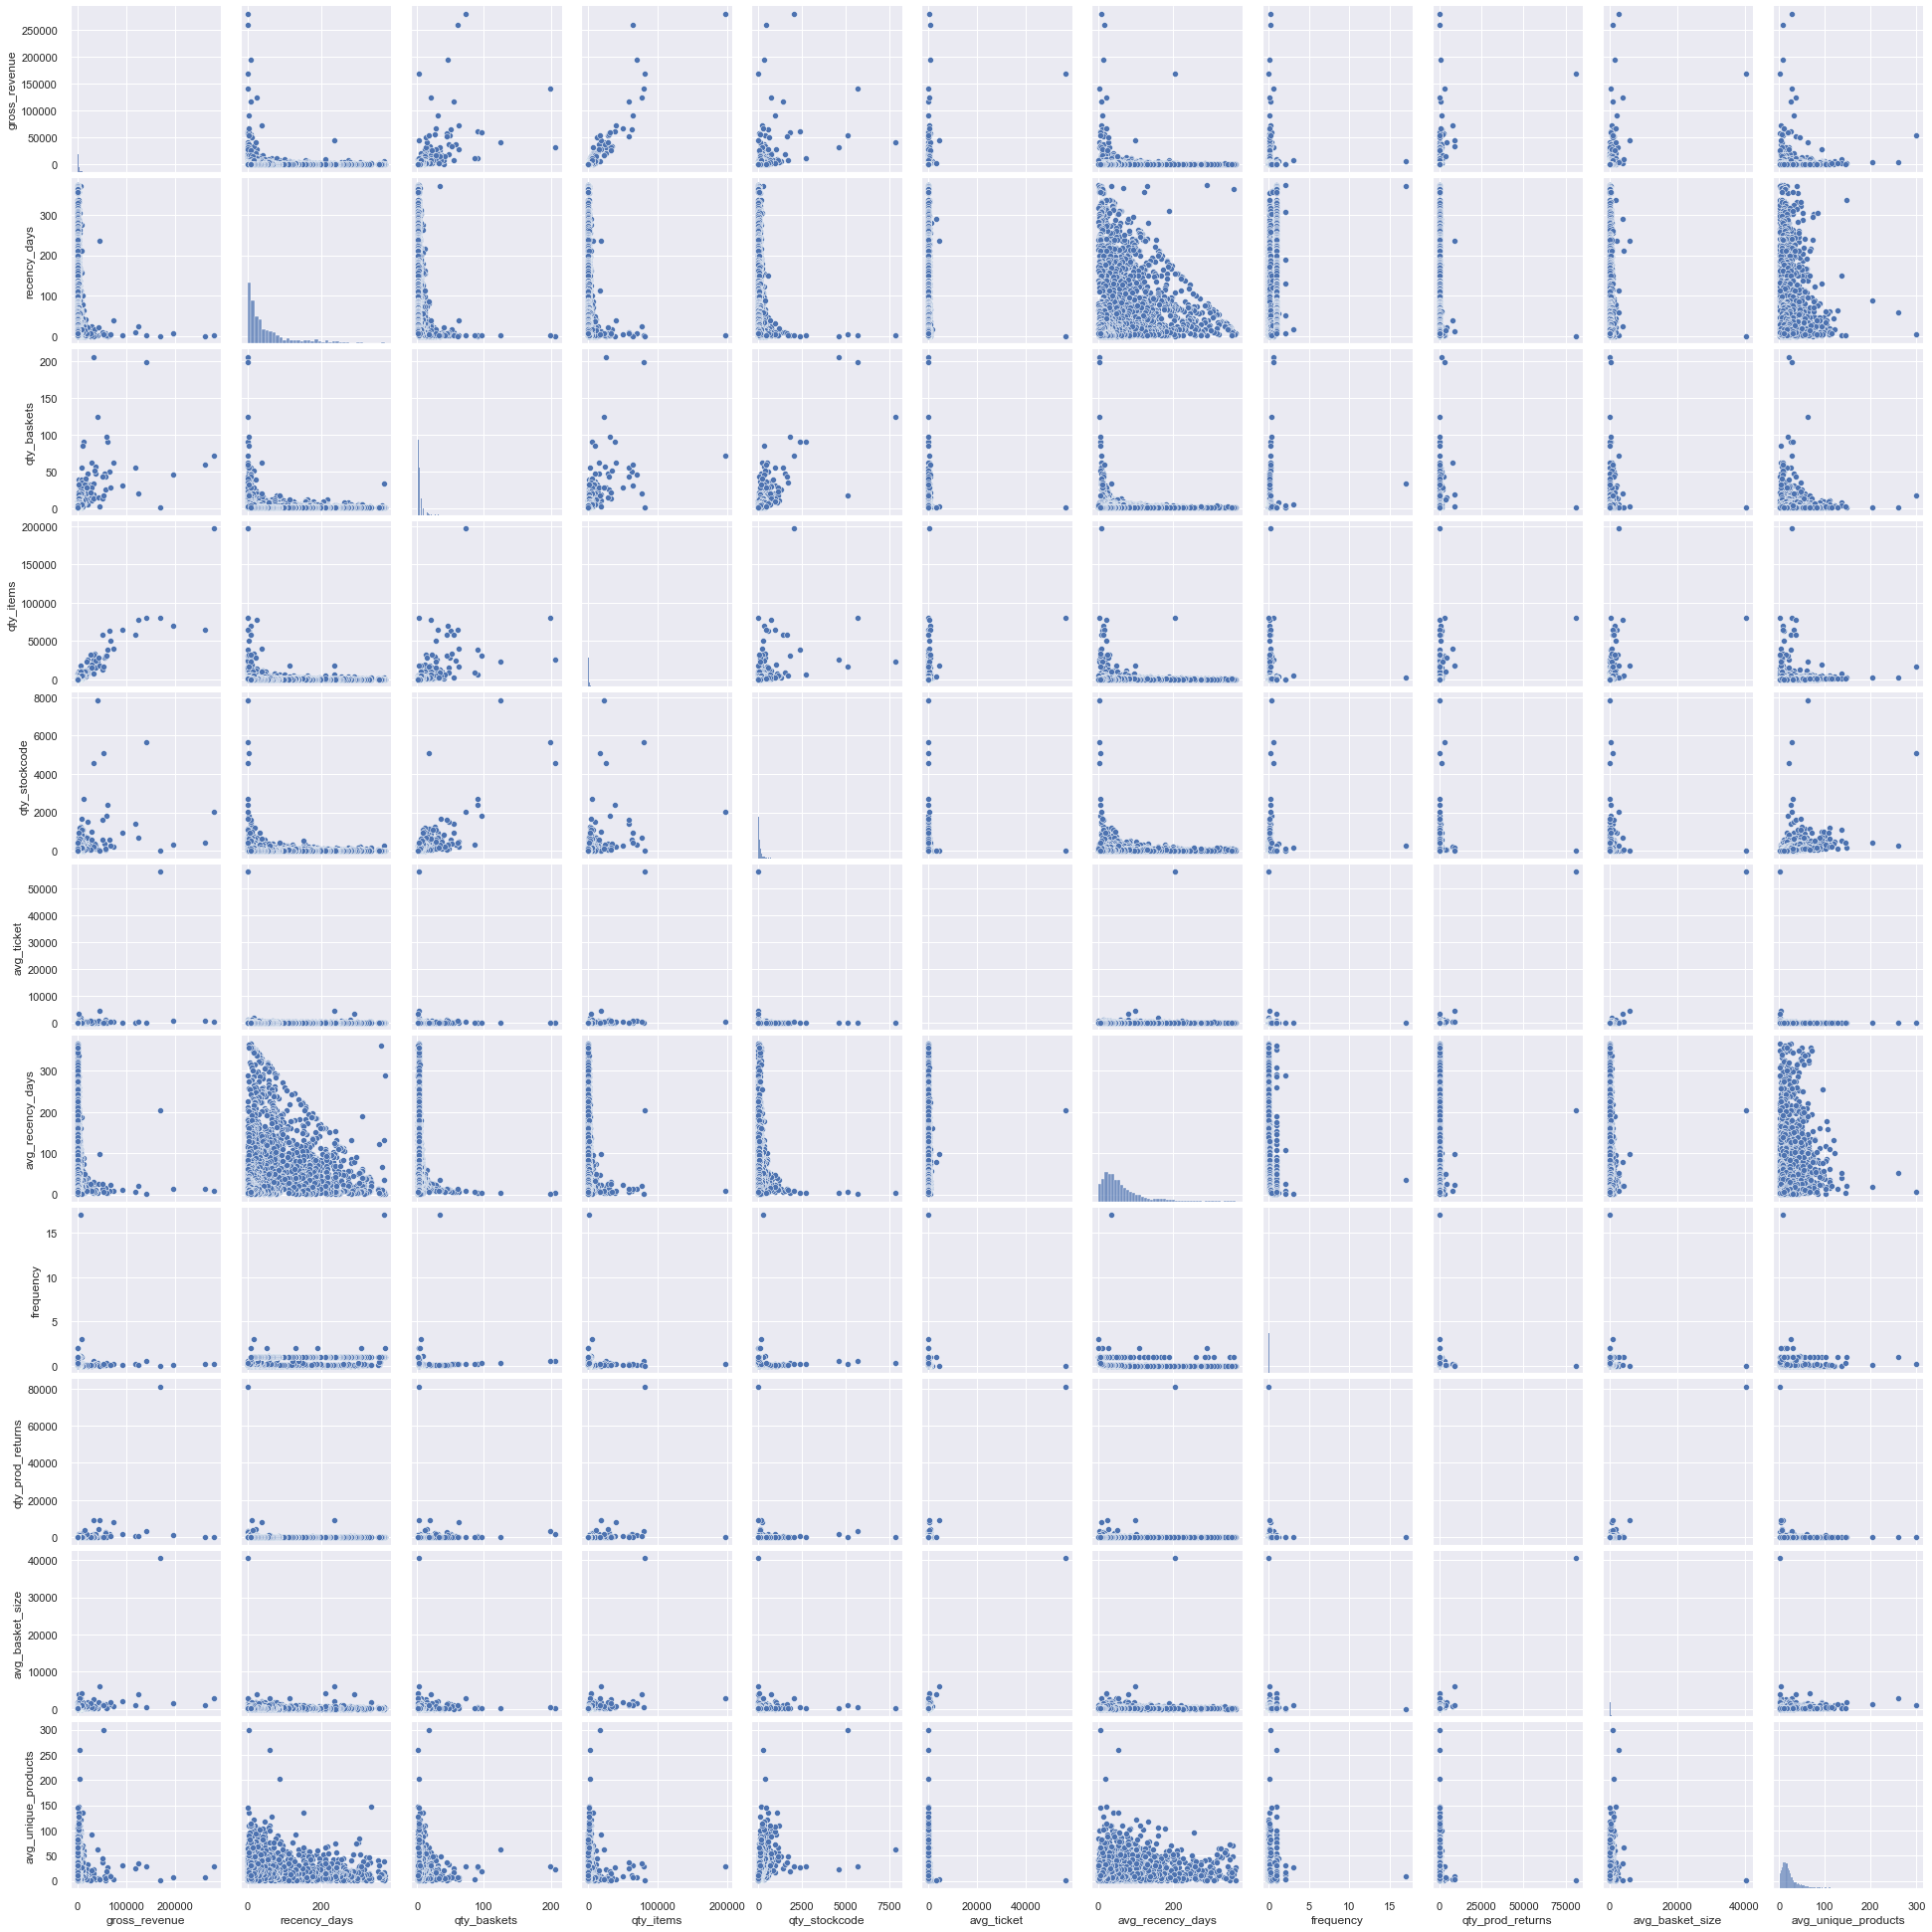

In [82]:
plt.figure(figsize=(20,15))
sns.pairplot(df42);

# Data Preparation

In [64]:
df5 = df4.copy()

In [65]:
df5.head()

,customer_id,gross_revenue,recency_days,qty_baskets,qty_items,qty_stockcode,avg_ticket,avg_recency_days,frequency,qty_prod_returns,avg_basket_size,avg_unique_products
0,17850,"5,391.21",372.00,34.00,"1,733.00",297.00,18.15,35.50,17.00,40.00,50.97,8.74
1,13047,"3,232.59",56.00,9.00,"1,390.00",171.00,18.90,27.25,0.03,35.00,154.44,19.00
2,12583,"6,705.38",2.00,15.00,"5,028.00",232.00,28.90,23.19,0.04,50.00,335.20,15.47
3,13748,948.25,95.00,5.00,439.00,28.00,33.87,92.67,0.02,0.00,87.80,5.60
4,15100,876.00,333.00,3.00,80.00,3.00,292.00,8.60,0.07,22.00,26.67,1.00


In [66]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['invoice_freq'] = ss.fit_transform(df5[['invoice_freq']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])
#df5['returns'] = ss.fit_transform(df5[['returns']])

KeyError: "None of [Index(['invoice_freq'], dtype='object')] are in the [columns]"

In [67]:
# ss = pp.MinMaxScaler()

# df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
# df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
# df5['invoice_freq'] = ss.fit_transform(df5[['invoice_freq']])
# df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])
# #df5['returns'] = ss.fit_transform(df5[['returns']])

In [68]:
df5.head()

,customer_id,gross_revenue,recency_days,qty_baskets,qty_items,qty_stockcode,avg_ticket,avg_recency_days,frequency,qty_prod_returns,avg_basket_size,avg_unique_products
0,17850,0.25,3.96,34.00,"1,733.00",297.00,18.15,35.50,17.00,40.00,50.97,8.74
1,13047,0.05,-0.11,9.00,"1,390.00",171.00,18.90,27.25,0.03,35.00,154.44,19.00
2,12583,0.37,-0.80,15.00,"5,028.00",232.00,28.90,23.19,0.04,50.00,335.20,15.47
3,13748,-0.17,0.40,5.00,439.00,28.00,33.87,92.67,0.02,0.00,87.80,5.60
4,15100,-0.18,3.46,3.00,80.00,3.00,292.00,8.60,0.07,22.00,26.67,1.00


# Feature Selection

In [ ]:
df6 = df5.copy()

# Hypermarameter Fine-Tunning

In [ ]:
df7 = df6.copy()
X =df7.drop(columns=['customer_id'])
X.head()

In [ ]:
clusters = [2,3,4,5,6,7]

## Within-Cluster Sum of Square (WSS)

In [ ]:
wss = []

for k in clusters:
    # model definition
    kmeans = c.KMeans (init='random', 
                       n_clusters=k, 
                       n_init=10, #init random inicia o centroide aleatoriamente, n_init 
                       max_iter = 300, 
                       random_state =42) # random state define um estado aleatório fixo
    
    # model training
    kmeans.fit( X )
    
    # validation
    wss.append(kmeans.inertia_) # generates a wss value for each k
    
# wss plot - elbow method
plt.plot (clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Square')
plt.title('WSS vs. K')

print(wss)

## Within-Cluster Sum of Square (WSS) vs. Silhouette Score

In [ ]:
# yellow brick

kmeans_y= KElbowVisualizer(c.KMeans(), k=clusters, timings=False);
kmeans_y.fit(X);
kmeans_y.show();

In [ ]:
# yellow brick

kmeans_y= KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False);
kmeans_y.fit(X);
kmeans_y.show();


## Silhouette Analysis

In [ ]:
# divmod input parameters are numerator and denomitor
# divmod outputs are quotient and remainder
x,y=divmod(5,2)
print(x,y)

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(25,18))

for k in clusters:
    km = c.KMeans (n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, r = divmod(k,2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick',ax=ax[q-1][r])
    visualizer.fit(X)
    visualizer.finalize()

# Model training

In [ ]:
df8 = df7.copy()

## K-Means

In [ ]:
# model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# model clustering
# labels = kmeans.predict(X) # outra maneira de fazer
labels = kmeans.labels_
print(labels)

## Cluster Validation

In [ ]:
# WSS 
print('WSS value: {}'.format(kmeans.inertia_))

# SS 
print('SS value:  {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

# Cluster Analysis

In [ ]:
df9 = df8.copy()
df9['cluster']=labels
df9.head()

## Visualization Inspection

In [ ]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()


## 2d Plot

In [ ]:
df9.head()

In [ ]:
# df_viz = df9.drop(columns='customer_id', axis=1)
# sns.pairplot(df_viz, hue='cluster')

## UMAP

In [ ]:
X.head()

In [ ]:
reducer = umap.UMAP (n_neighbors=40, random_state=42) # n_neighbors = altera a visualização do cluster, meio que "zoom in/zoom out"
embedding = reducer.fit_transform(X)

In [ ]:
# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz)

## Cluster Profile

In [ ]:
df9.head()

In [ ]:
# number of customers on each cluster
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['customer_percentage'] = (df_cluster['customer_id'] / df_cluster['customer_id'].sum())*100

# avg gross_revenue
df_avg_grossrevenue = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_grossrevenue, how='inner', on='cluster')

# avg recency_days
df_avg_recencydays = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recencydays, how='inner', on='cluster')

# avg incoive_freq
df_avg_invoicefreq = df9[['invoice_freq','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoicefreq, how='inner', on='cluster')

#avg ticket
df_avg_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner', on='cluster')

df_cluster

### Cluster 01:  ( Candidato à Insider ) ** ATUALIZAR **
    - Número de customers: 6 (0.14% do customers )
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: $182.182,00 dólares
        
### Cluster 02:
    - Número de customers: 31 (0.71% do customers )
    - Recência em média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: $40.543,52 dólares

### Cluster 00:
    - Número de customers: 4.335 (99% do customers )
    - Recência em média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: $1.372,57 dólares

# Deploy to Production